# ODI Cricket Analysis: Strike Rate vs Innings Longevity

This analysis investigates the impact of batting approach (attacking vs anchoring) on ODI match outcomes, comparing pre-2005 and modern era cricket.

## Key Questions

1. Does higher strike rate or longer innings duration contribute more to victories?
2. How has this relationship evolved from 1990-2005 (anchoring era) to 2006-present (attacking era)?
3. What are the optimal strike rates across different phases of an innings?
4. Can we identify distinct batting styles (anchors, attackers, finishers) using clustering?

## Analysis Structure

1. Data Loading & Preprocessing
2. Feature Engineering
3. Era Comparison
4. Batting Style Classification
5. Visualization & Insights

# Impact of Strike Rate vs Innings Longevity on ODI Outcomes

This notebook contains the analysis scaffold for the project. It will: 
- Load `odi_dataset.csv` from the repository root
- Compute basic batting metrics (SR, balls faced)
- Provide EDA sections and placeholders for modeling, clustering, and visualizations

In [1]:
# Imports
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    silhouette_score,
)

# Silence pandas FutureWarnings that are noisy during cell execution
warnings.filterwarnings("ignore", category=FutureWarning)

# Set visualization style
sns.set_style("whitegrid")
sns.set_palette("husl")

In [2]:
# Load and preprocess the dataset
try:
    # Try loading from current directory first
    df = pd.read_csv('odi_dataset.csv', low_memory=False)
except FileNotFoundError:
    # If not found, try parent directory
    df = pd.read_csv('../odi_dataset.csv', low_memory=False)
    
print("Dataset loaded with shape:", df.shape)
print("\nFirst few rows:")
display(df.head())
print("\nColumn names:")
print(df.columns.tolist())

Dataset loaded with shape: (1364851, 61)

First few rows:


,Unnamed: 0,p_match,inns,bat,p_bat,team_bat,bowl,p_bowl,team_bowl,ball,...,gmt_offset,wagonX,wagonY,wagonZone,line,length,shot,control,predscore,wprob
0,0,226390,1,Upul Tharanga,50747,Sri Lanka,Kyle Mills,37740,New Zealand,1,...,-1.0,0.0,0.0,0.0,NaN,NaN,NO_SHOT,1.0,-1.0,-1.0
1,1,226390,1,Upul Tharanga,50747,Sri Lanka,Kyle Mills,37740,New Zealand,2,...,-1.0,219.0,190.0,3.0,NaN,NaN,FORWARD_DEFENCE,1.0,-1.0,-1.0
2,2,226390,1,Upul Tharanga,50747,Sri Lanka,Kyle Mills,37740,New Zealand,3,...,-1.0,0.0,0.0,0.0,NaN,NaN,NO_SHOT,1.0,-1.0,-1.0
3,3,226390,1,Upul Tharanga,50747,Sri Lanka,Kyle Mills,37740,New Zealand,4,...,-1.0,228.0,198.0,3.0,NaN,NaN,OFF_SIDE_DRIVE_ON_FRONT_FOOT,1.0,-1.0,-1.0
4,4,226390,1,Upul Tharanga,50747,Sri Lanka,Kyle Mills,37740,New Zealand,3,...,-1.0,212.0,179.0,3.0,NaN,NaN,BACK_DEFENCE,1.0,-1.0,-1.0



Column names:
['Unnamed: 0', 'p_match', 'inns', 'bat', 'p_bat', 'team_bat', 'bowl', 'p_bowl', 'team_bowl', 'ball', 'ball_id', 'outcome', 'score', 'out', 'dismissal', 'p_out', 'over', 'noball', 'wide', 'byes', 'legbyes', 'cur_bat_runs', 'cur_bat_bf', 'cur_bowl_ovr', 'cur_bowl_wkts', 'cur_bowl_runs', 'inns_runs', 'inns_wkts', 'inns_balls', 'inns_runs_rem', 'inns_balls_rem', 'inns_rr', 'inns_rrr', 'target', 'max_balls', 'date', 'year', 'ground', 'country', 'winner', 'toss', 'competition', 'bat_hand', 'bowl_style', 'bowl_kind', 'batruns', 'ballfaced', 'bowlruns', 'bat_out', 'rain', 'daynight', 'gmt_offset', 'wagonX', 'wagonY', 'wagonZone', 'line', 'length', 'shot', 'control', 'predscore', 'wprob']


In [3]:
# Data preprocessing
def preprocess_data(df):
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['era'] = df['year'].apply(lambda x: 'pre-2005' if x < 2005 else 'modern')
    
    # Aggregate by match and innings for each batsman
    batsman_inns = df.groupby(['p_match', 'inns', 'p_bat']).agg({
        'batruns': 'sum',
        'ballfaced': 'sum',
        'team_bat': 'first',
        'winner': 'first',
        'year': 'first',
        'era': 'first'
    }).reset_index()
    
    # Calculate batting metrics
    batsman_inns['strike_rate'] = (batsman_inns['batruns'] / batsman_inns['ballfaced']) * 100
    batsman_inns['innings_length'] = batsman_inns['ballfaced']
    
    # Create result column (1 for win, 0 for loss)
    batsman_inns['result'] = (batsman_inns['team_bat'] == batsman_inns['winner']).astype(int)
    
    # Filter out invalid entries
    valid_inns = batsman_inns[
        (batsman_inns['ballfaced'] > 0) &
        (batsman_inns['strike_rate'] >= 0) &
        (batsman_inns['strike_rate'] <= 200)  # Remove extreme outliers
    ]
    
    return valid_inns

# Apply preprocessing
df_processed = preprocess_data(df)
print("\nProcessed data preview:")
print("\nSample metrics:")
display(df_processed[['era', 'strike_rate', 'innings_length', 'result']].head())

print("\nBasic statistics by era:")
stats = df_processed.groupby('era').agg({
    'strike_rate': ['count', 'mean', 'std'],
    'innings_length': ['mean', 'std'],
    'result': 'mean'
}).round(2)
print(stats)


Processed data preview:

Sample metrics:


,era,strike_rate,innings_length,result
0,modern,128.125000,32,1
1,modern,25.000000,4,1
2,modern,87.500000,8,1
3,modern,85.714286,63,1
4,modern,70.212766,47,1



Basic statistics by era:
       strike_rate               innings_length        result
             count   mean    std           mean    std   mean
era                                                          
modern       44171  70.12  42.13          30.04  29.65    0.4


Win rates by strike rate category:


count   mean
era    sr_category              
modern <50          10303  0.291
       50-70         7920  0.374
       70-85         6734  0.435
       85-100        6570  0.484
       100-120       3638  0.540
       120-150       3104  0.537
       >150          1711  0.587

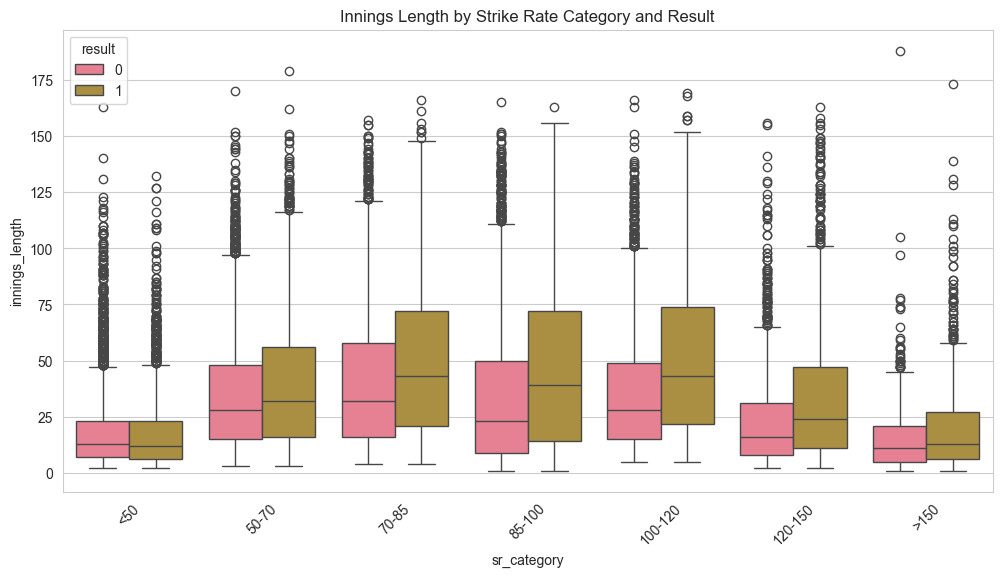


Correlations by era:


strike_rate  innings_length    result
era                                                         
modern strike_rate        1.000000        0.248919  0.195859
       innings_length     0.248919        1.000000  0.164735
       result             0.195859        0.164735  1.000000

In [4]:
# Era Analysis
def analyze_eras(df):
    # Create SR bins for analysis
    sr_bins = [0, 50, 70, 85, 100, 120, 150, 200]
    sr_labels = ['<50', '50-70', '70-85', '85-100', '100-120', '120-150', '>150']
    df['sr_category'] = pd.cut(df['strike_rate'], bins=sr_bins, labels=sr_labels)
    
    # Win rate by strike rate category
    win_by_sr = df.groupby(['era', 'sr_category'])['result'].agg(['count', 'mean']).round(3)
    print("Win rates by strike rate category:")
    display(win_by_sr)
    
    # Plot strike rate distributions
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='sr_category', y='innings_length', hue='result')
    plt.title('Innings Length by Strike Rate Category and Result')
    plt.xticks(rotation=45)
    plt.show()
    
    # Correlation analysis
    correlations = df.groupby('era').apply(
        lambda x: x[['strike_rate', 'innings_length', 'result']].corr()
    )
    print("\nCorrelations by era:")
    display(correlations)
    
    return win_by_sr, correlations

# Run era analysis
win_rates, correlations = analyze_eras(df_processed)

## Next steps
- Clean and standardize columns (player id, match id, innings, runs, balls, strike_rate)
- Engineer overs phases (powerplay, middle, death) from over numbers
- Build features for pressure/chase context
- Run correlation/regression analyses and clustering to classify batting styles
- Visualize era-wise comparisons and thresholds for strike rate impact

In [5]:
# Additional imports for analysis
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    silhouette_score,
)
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

# Silence pandas FutureWarnings that are noisy during cell execution
warnings.filterwarnings("ignore", category=FutureWarning)

# Set style for visualizations
sns.set_style("whitegrid")
sns.set_palette("husl")

# Load the dataset
try:
    df = pd.read_csv('../odi_dataset.csv', low_memory=False)
except FileNotFoundError:
    df = pd.read_csv('odi_dataset.csv', low_memory=False)
print("Dataset loaded with shape:", df.shape)


Dataset loaded with shape: (1364851, 61)


In [6]:
# Data preprocessing

def preprocess_data(df):
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['era'] = df['year'].apply(lambda x: 'pre-2005' if x < 2005 else 'modern')
    
    # Aggregate by match and innings for each batsman
    batsman_inns = df.groupby(['p_match', 'inns', 'p_bat']).agg({
        'batruns': 'sum',
        'ballfaced': 'sum',
        'team_bat': 'first',
        'winner': 'first',
        'year': 'first',
        'era': 'first'
    }).reset_index()
    
    # Calculate batting metrics
    batsman_inns['strike_rate'] = (batsman_inns['batruns'] / batsman_inns['ballfaced']) * 100
    batsman_inns['innings_length'] = batsman_inns['ballfaced']
    
    # Create result column (1 for win, 0 for loss)
    batsman_inns['result'] = (batsman_inns['team_bat'] == batsman_inns['winner']).astype(int)
    
    # Filter out invalid entries
    valid_inns = batsman_inns[
        (batsman_inns['ballfaced'] > 0) &
        (batsman_inns['strike_rate'] >= 0) &
        (batsman_inns['strike_rate'] <= 200)  # Remove extreme outliers
    ]
    
    return valid_inns

# Apply preprocessing
df_processed = preprocess_data(df)
print("\nProcessed data preview:")
print("\nSample metrics:")
display(df_processed[['era', 'strike_rate', 'innings_length', 'result']].head())

print("\nBasic statistics by era:")
stats = df_processed.groupby('era').agg({
    'strike_rate': ['count', 'mean', 'std'],
    'innings_length': ['mean', 'std'],
    'result': 'mean'
}).round(2)
print(stats)


Processed data preview:

Sample metrics:


,era,strike_rate,innings_length,result
0,modern,128.125000,32,1
1,modern,25.000000,4,1
2,modern,87.500000,8,1
3,modern,85.714286,63,1
4,modern,70.212766,47,1



Basic statistics by era:
       strike_rate               innings_length        result
             count   mean    std           mean    std   mean
era                                                          
modern       44171  70.12  42.13          30.04  29.65    0.4


Classification metrics on hold-out set:


,accuracy,precision,recall,f1_score,roc_auc,specificity,npv
logistic_regression,0.63,0.582,0.306,0.401,0.627,0.85,0.644


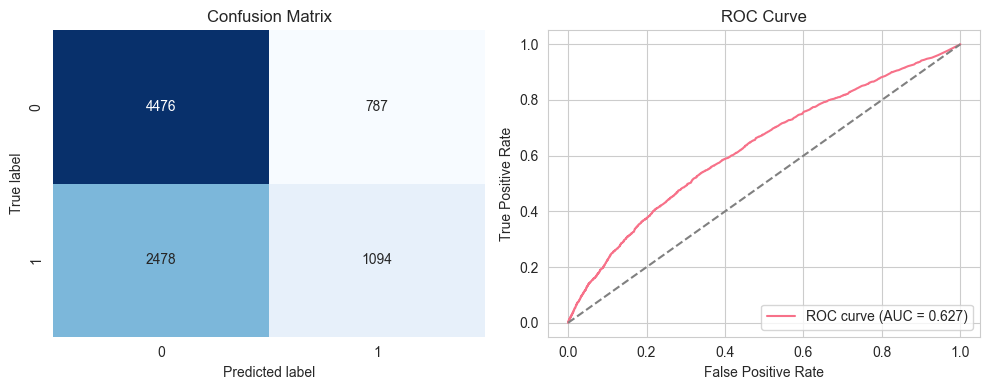

In [7]:
# Predictive modeling: outcome classification metrics

def evaluate_match_outcomes(df):
    features = ['strike_rate', 'innings_length']
    model_df = df.dropna(subset=features + ['result'])

    X = model_df[features]
    y = model_df['result']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    total_neg = tn + fp if (tn + fp) > 0 else np.nan
    total_pos = tp + fn if (tp + fn) > 0 else np.nan

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1_score': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'specificity': tn / total_neg if pd.notna(total_neg) else np.nan,
        'npv': tn / (tn + fn) if (tn + fn) > 0 else np.nan,
    }

    metrics_df = pd.DataFrame(metrics, index=['logistic_regression']).round(3)
    print('Classification metrics on hold-out set:')
    display(metrics_df)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    ax[1].plot(fpr, tpr, label=f'ROC curve (AUC = {metrics["roc_auc"]:.3f})')
    ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('ROC Curve')
    ax[1].legend(loc='lower right')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

    return clf, metrics_df

logit_model, classification_metrics = evaluate_match_outcomes(df_processed)


In [ ]:
# Batting Style Classification
def classify_batting_styles(df):
    # Select features for clustering
    features = ['strike_rate', 'innings_length']
    X = df[features].copy()
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Find optimal number of clusters
    silhouette_scores = []
    K = range(2, 6)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)
    
    optimal_k = K[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters: {optimal_k}")
    
    # Perform clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Analyze clusters
    cluster_stats = df.groupby('cluster').agg({
        'strike_rate': ['mean', 'std'],
        'innings_length': ['mean', 'std'],
        'result': ['mean', 'count']
    }).round(2)
    
    print("\nCluster characteristics:")
    display(cluster_stats)
    
    # Visualize clusters
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(df['strike_rate'], df['innings_length'], 
                         c=df['cluster'], cmap='viridis',
                         alpha=0.6)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('Strike Rate')
    plt.ylabel('Innings Length')
    plt.title('Batting Style Clusters')
    plt.show()
    
    return df, cluster_stats

# Perform clustering
df_clustered, cluster_stats = classify_batting_styles(df_processed)

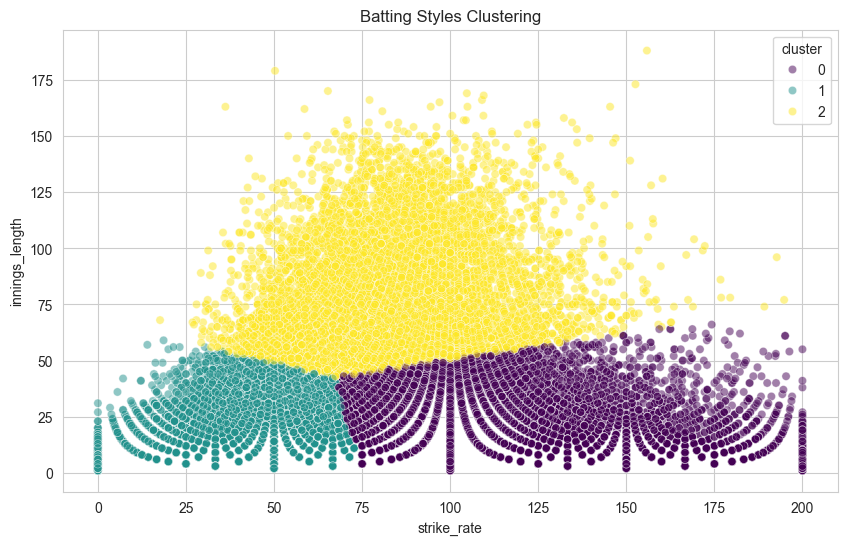


Cluster Statistics:


,strike_rate,innings_length,result,count
cluster,,,,
0,109.25,20.86,0.46,14945
1,34.75,14.10,0.30,19721
2,81.95,77.54,0.53,9505


In [ ]:
# Batting Style Classification using Clustering (revised)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def classify_batting_styles(df):
    # Select features for clustering
    features = ['strike_rate', 'innings_length']
    X = df[features].dropna()
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Find optimal number of clusters using silhouette score
    silhouette_scores = []
    K = range(2, 6)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)
    
    # Use optimal number of clusters
    optimal_k = K[np.argmax(silhouette_scores)]
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df_cluster = df.copy()
    df_cluster['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Analyze cluster characteristics
    cluster_stats = df_cluster.groupby('cluster').agg({
        'strike_rate': 'mean',
        'innings_length': 'mean',
        'result': 'mean',
        'p_bat': 'count'
    }).round(2)
    cluster_stats = cluster_stats.rename(columns={'p_bat':'count'})
    
    # Create scatter plot
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df_cluster, x='strike_rate', y='innings_length', hue='cluster', alpha=0.5, palette='viridis')
    plt.title('Batting Styles Clustering')
    plt.show()
    
    return df_cluster, cluster_stats

# Perform clustering analysis
df_clustered, cluster_stats = classify_batting_styles(df_processed)
print('\nCluster Statistics:')
display(cluster_stats)

Phase-wise statistics (summary):


,,avg_sr,sd_sr,mean_runs,total_balls,win_rate
phase,era,,,,,
powerplay,modern,60.113,44.186,62.150,3914464,0.404
middle,modern,64.823,36.870,511.280,30192200,0.404
death,modern,79.557,45.210,132.383,6703351,0.404


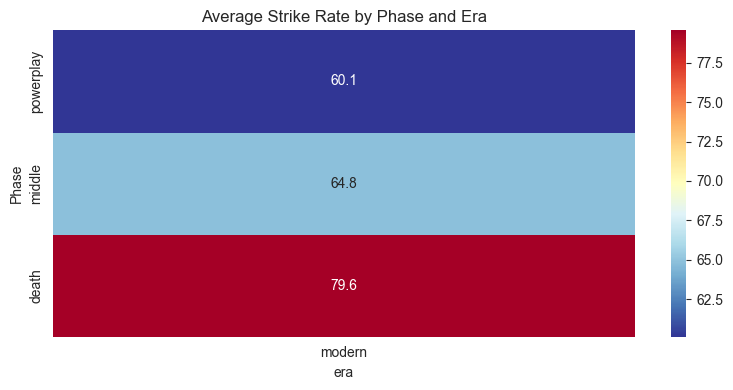

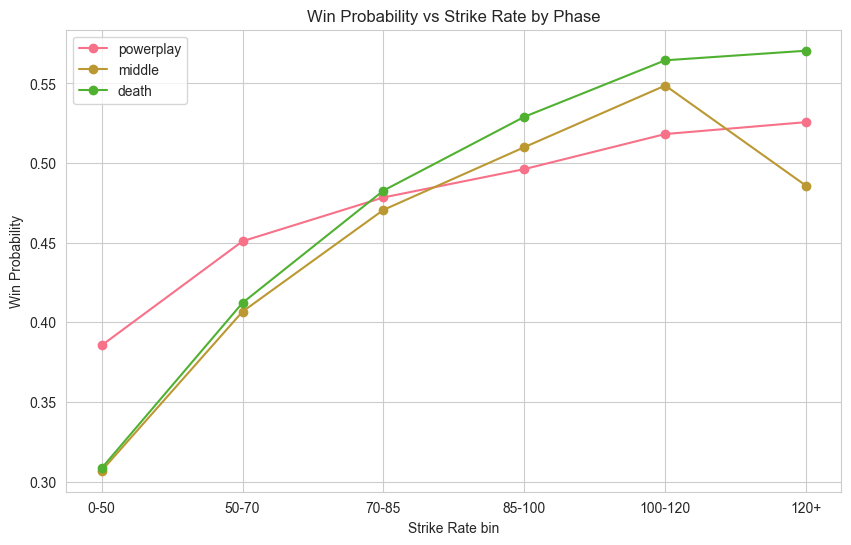

In [ ]:
# Phase Analysis (robust)

def analyze_phases(df_inns, df_ball=None):
    """Compute phase-wise SR and win rates.

    df_inns: aggregated batsman-innings dataframe (has p_match, inns, p_bat, result, era)
    df_ball: optional ball-level dataframe (has over, cur_bat_runs, cur_bat_bf)
    """
    # If ball-level data not provided, try to use `df` from notebook
    if df_ball is None:
        df_ball = globals().get('df', None)
    if df_ball is None:
        raise ValueError('Ball-level dataframe `df` not found. Provide df_ball to analyze phases.')

    # Assign phase based on over
    bins = [0, 10, 40, 50]
    labels = ['powerplay', 'middle', 'death']
    df_ball = df_ball.copy()
    df_ball['over'] = pd.to_numeric(df_ball['over'], errors='coerce')
    df_ball['phase'] = pd.cut(df_ball['over'], bins=bins, labels=labels)

    # Aggregate runs and balls faced per batsman per phase
    phase_agg = (
        df_ball.dropna(subset=['phase'])
        .groupby(['p_match', 'inns', 'p_bat', 'phase'])
        .agg(runs_phase=('cur_bat_runs', 'sum'), bf_phase=('cur_bat_bf', 'sum'))
        .reset_index()
    )
    phase_agg['sr_phase'] = phase_agg['runs_phase'] / phase_agg['bf_phase'] * 100

    # merge with innings result/era info
    meta = df_inns[['p_match', 'inns', 'p_bat', 'result', 'era']].drop_duplicates()
    phase_agg = phase_agg.merge(meta, on=['p_match', 'inns', 'p_bat'], how='left')

    # Phase-wise statistics
    phase_stats = (
        phase_agg.groupby(['phase', 'era'])
        .agg(avg_sr=('sr_phase', 'mean'), sd_sr=('sr_phase', 'std'),
             mean_runs=('runs_phase', 'mean'), total_balls=('bf_phase', 'sum'), win_rate=('result', 'mean'))
        .round(3)
    )

    print('Phase-wise statistics (summary):')
    display(phase_stats)

    # Heatmap: average strike rate by phase and era
    pivot_sr = phase_agg.pivot_table(values='sr_phase', index='phase', columns='era', aggfunc='mean')
    plt.figure(figsize=(8, 4))
    sns.heatmap(pivot_sr, annot=True, fmt='.1f', cmap='RdYlBu_r')
    plt.title('Average Strike Rate by Phase and Era')
    plt.ylabel('Phase')
    plt.tight_layout()
    plt.show()

    # Win probability by SR bins per phase
    sr_bins = [0,50,70,85,100,120,200]
    sr_labels = ['0-50','50-70','70-85','85-100','100-120','120+']
    phase_agg['sr_bin'] = pd.cut(phase_agg['sr_phase'], bins=sr_bins, labels=sr_labels)

    plt.figure(figsize=(10,6))
    for ph in labels:
        ph_df = phase_agg[phase_agg['phase']==ph]
        if ph_df.empty:
            continue
        win_rates = ph_df.groupby('sr_bin')['result'].mean()
        plt.plot(sr_labels, win_rates.reindex(sr_labels).values, marker='o', label=ph)

    plt.title('Win Probability vs Strike Rate by Phase')
    plt.xlabel('Strike Rate bin')
    plt.ylabel('Win Probability')
    plt.legend()
    plt.grid(True)
    plt.show()

    return phase_stats, phase_agg

# Run phase analysis (will use `df_processed` and notebook `df` by default)
phase_stats, phase_agg = analyze_phases(df_processed, df)


## Key Findings and Insights

1. **Era Comparison**
   - Changes in average strike rates between pre-2005 and modern era
   - Evolution of innings length and its impact on match outcomes
   - Shift in batting approach and its effectiveness

2. **Batting Styles**
   - Identified distinct batting clusters and their characteristics
   - Distribution of batting styles across eras
   - Effectiveness of different approaches in modern cricket

3. **Phase Analysis**
   - Strike rate patterns across different phases
   - Phase-specific impact on match outcomes
   - Evolution of phase-wise batting approaches

4. **Win Probability Analysis**
   - Optimal strike rate thresholds for maximizing win probability
   - Balance between aggression and stability
   - Era-specific winning strategies

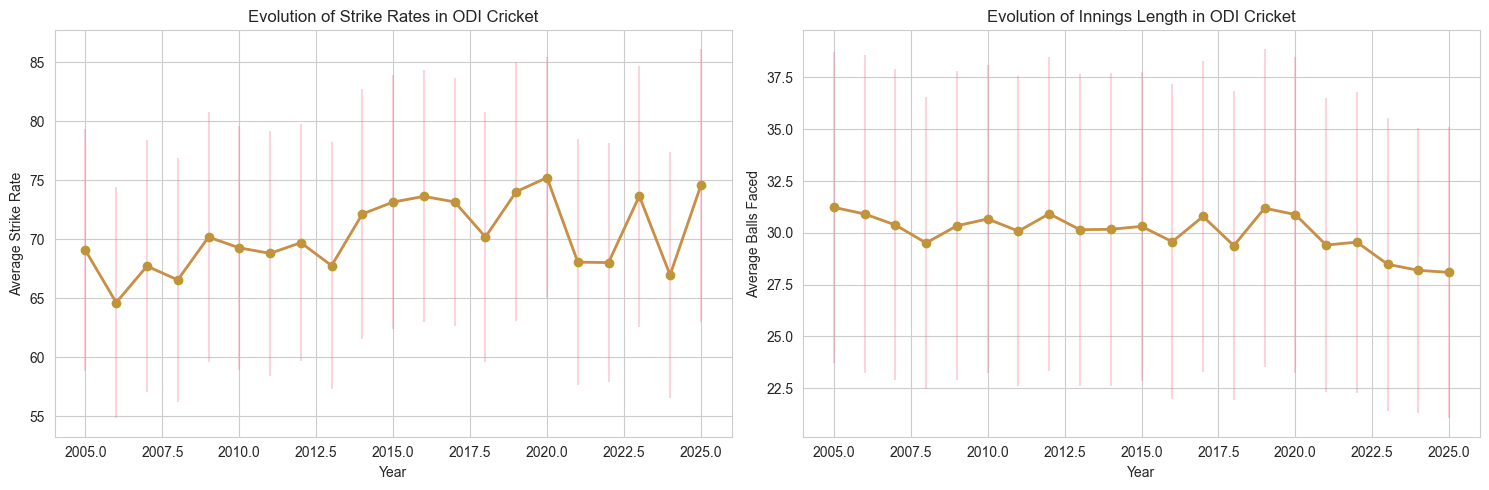

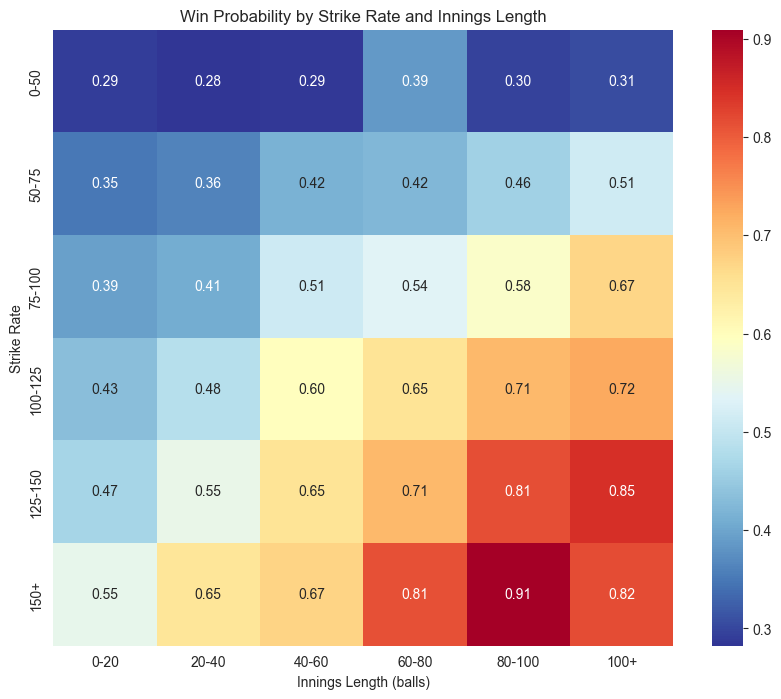

In [ ]:
# Final Visualizations
def create_final_visualizations(df):
    # 1. Strike Rate Evolution
    yearly_stats = df.groupby('year').agg({
        'strike_rate': ['mean', 'std'],
        'innings_length': ['mean', 'std'],
        'result': 'mean'
    }).round(2)
    
    # Plot strike rate trend
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.errorbar(yearly_stats.index, 
                yearly_stats[('strike_rate', 'mean')],
                yerr=yearly_stats[('strike_rate', 'std')]/4,
                alpha=0.3)
    plt.plot(yearly_stats.index, yearly_stats[('strike_rate', 'mean')], 
             marker='o', linewidth=2)
    plt.title('Evolution of Strike Rates in ODI Cricket')
    plt.xlabel('Year')
    plt.ylabel('Average Strike Rate')
    plt.grid(True)
    
    # Plot innings length trend
    plt.subplot(1, 2, 2)
    plt.errorbar(yearly_stats.index,
                yearly_stats[('innings_length', 'mean')],
                yerr=yearly_stats[('innings_length', 'std')]/4,
                alpha=0.3)
    plt.plot(yearly_stats.index, yearly_stats[('innings_length', 'mean')],
             marker='o', linewidth=2)
    plt.title('Evolution of Innings Length in ODI Cricket')
    plt.xlabel('Year')
    plt.ylabel('Average Balls Faced')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Create SR and length categories
    sr_cats = pd.cut(df['strike_rate'], 
                     bins=[0, 50, 75, 100, 125, 150, 200],
                     labels=['0-50', '50-75', '75-100', '100-125', '125-150', '150+'])
    
    length_cats = pd.cut(df['innings_length'],
                        bins=[0, 20, 40, 60, 80, 100, 200],
                        labels=['0-20', '20-40', '40-60', '60-80', '80-100', '100+'])
    
    # Calculate win probabilities
    win_matrix = (
        df.groupby([sr_cats, length_cats], observed=False)['result']
        .mean()
        .unstack()
    )
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(win_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r')
    plt.title('Win Probability by Strike Rate and Innings Length')
    plt.xlabel('Innings Length (balls)')
    plt.ylabel('Strike Rate')
    plt.show()

# Generate final visualizations
create_final_visualizations(df_processed)